<p style="background:#484E6E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b> Lending Club</b><br>
    <br>Exploratory Data Analysis - Model 01<br><br> 
</p>

<p style="text-align: right;">Module 3: Machine Learning<br>
Sprint 3: Unsupervised Learning & Hyperparameter Tuning<br>
Author : Renato Mariano</p>

<h1 style="color:#484E6E">Introduction </h1>

This data science project aims at automating lending decisions for LendingClub. It is a series of notebooks starting by 01_Data_Sampling_LendingClub.

<h2 style="color:#484E6E">Library Imports and Notebook Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from rapidfuzz import process

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency, pointbiserialr

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext blackcellmagic

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#484E6E">Exploratory Data Analysis</h1>

<h2 style="color:#484E6E">Initial Exploration</h2>

Due to the size of our dataset the data was sampled in a different notebook. The reading of the data was made in polars and the separation was made with train_test_split from Sci-Kit Learn.

In this previous notebook the accepted dataframe was cleaned to contain the same columns as the rejected dataframe. In both sets, the duplicated were removed.

In [3]:
start = time()
df = pd.read_csv("data/exported/full_train.csv", skiprows=lambda x: x % 4)
end = time()
print(f"Read accepted train with pandas: {(end-start):.3f} sec\n")
print(f"The shape of the data is: {df.shape}\n")
df.head(5)

Read accepted train with pandas: 8.104 sec

The shape of the data is: (118439, 9)



,Amount_Requested,Loan_Title,Risk_Score,Debt-To-Income_Ratio,Zip_Code,State,Employment_Length,Policy_Code,Application_Result
0,10000.000,Debt consolidation,NaN,21.160,207xx,MD,< 1 year,0.000,Rejected
1,5000.000,Other,592.000,5.970,150xx,PA,< 1 year,0.000,Rejected
2,1000.000,debt_consolidation,552.000,1.810,212xx,MD,< 1 year,0.000,Rejected
3,10000.000,Major purchase,NaN,207.210,376xx,TN,< 1 year,0.000,Rejected
4,35000.000,Debt consolidation,NaN,100.000,967xx,HI,< 1 year,0.000,Rejected


As we removed the column that refers to the application date, it is normal that some duplicates will be found. They, however, don't represent the same request process and will not be dropped.

In [4]:
df[df.duplicated()].shape

(468, 9)

In [5]:
percent_missing = (df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
data_types = df.dtypes

pd.DataFrame({'Percent Missing': percent_missing, 'Data Type': data_types})

,Percent Missing,Data Type
Amount_Requested,0.000,float64
Application_Result,0.000,object
Debt-To-Income_Ratio,0.007,float64
Employment_Length,3.696,object
Loan_Title,0.093,object
Policy_Code,0.003,float64
Risk_Score,61.621,float64
State,0.000,object
Zip_Code,0.003,object


The dataframe presents only 8 features (which are originally from rejected) with different types. "Application Result" was generated in the previous notebook and contained rejected and accepted values. **Most of the columns do not present missing values**. **Risk score**, however, present about **61%** of NA. 

A possible treatment/fill to "Risk_Score" need to be proposed.

Let's explore further the dataset.

In [6]:
df.describe()

,Amount_Requested,Risk_Score,Debt-To-Income_Ratio,Policy_Code
count,118439.000,45456.000,118431.000,118436.000
mean,13245.905,641.857,126.492,0.081
std,14497.517,87.871,2633.341,0.283
min,0.000,0.000,-1.000,0.000
25%,5000.000,605.000,8.760,0.000
50%,10000.000,654.000,19.820,0.000
75%,20000.000,688.000,35.100,0.000
max,300000.000,986.000,517812.400,2.000


We will explore further these numerical features, but it is interesting to see that the **median Debt-to-income-ratio is almost 20**. This highlights that **a relevant part of the applicants present already debts**.

Furthermore,  Debt-To-Income Ratio presents -1 values, which probably represent borrowers that had no income.

In [7]:
df.describe(include="O").T

,count,unique,top,freq
Loan_Title,118329,958,Debt consolidation,30052
Zip_Code,118436,899,112xx,1125
State,118439,51,CA,14032
Employment_Length,114061,11,< 1 year,91517
Application_Result,118439,2,Rejected,109484


This description shows that **most of the applicants had less than 1 year of work experience, were applying for debt consolidation and had their application rejected**.

<h2 style="color:#484E6E">Univariate Analysis of Features</h2>

<h3 style="color:#484E6E">Application Result</h3>

In [8]:
palette_plt = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:grey",
    "tab:olive",
    "tab:cyan",
]

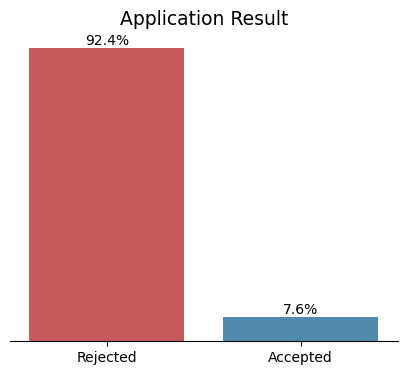

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.countplot(data=df, x="Application_Result", ax=ax, palette=(palette_plt[3], palette_plt[0]), alpha=0.85)

total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01 * total, f'{height/total:.1%}', ha='center')

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_yticklabels("")
ax.tick_params(axis='y',length=0)
ax.set_title("Application Result", fontsize=13.5)

sns.despine(left=True)

As commented in the previous notebook, the percentages for each target class are very similar to the full dataframe.

<h3 style="color:#484E6E">Outliers</h3>

How is the distribution of the numerical features and are outliers present in this dataset?

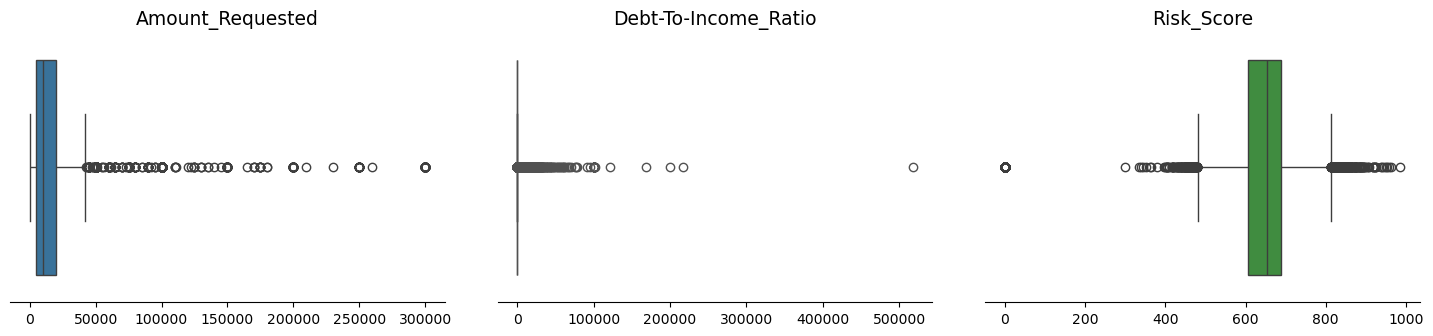

In [10]:
num_features = ["Amount_Requested", "Debt-To-Income_Ratio", "Risk_Score"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(num_features):
    sns.boxplot(data=df, x=col, ax=axes[i], color=palette_plt[i], saturation=0.65)
    sns.despine(left=True)
    
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticklabels("")
    axes[i].tick_params(axis='y',length=0)
    axes[i].set_title(num_features[i], fontsize=13.5)

plt.tight_layout(pad=3)

The above boxplots highlight both the range of these features and the outliers in the dataset. In general, all of these features are full of outliers.

We will present their distribution in more detail in the next sections.

<h3 style="color:#484E6E">Requested Loan Amounts</h3>

Let's start here by checking the Requested Loan Amounts and how these were distributed over the years.


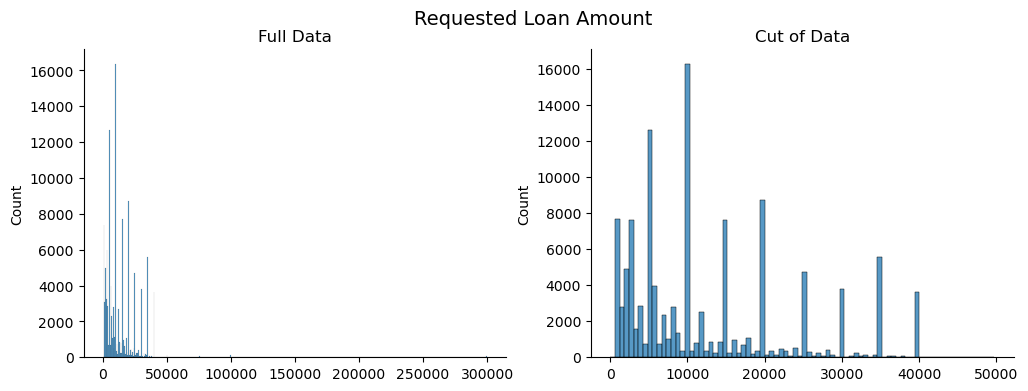

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=df, x="Amount_Requested", ax=axes[0], bins=500)
sns.histplot(data=df[df["Amount_Requested"] < 50_000], x="Amount_Requested", ax=axes[1])

plt.suptitle("Requested Loan Amount", fontsize=14)
axes[0].set(title="Full Data")
axes[1].set(title="Cut of Data")

for ax in axes:
    ax.set(xlabel="")
    sns.despine()

The requested amount varies between **0 (?) and 300_000 dollars**. Most of the data is however distributed between 500 and 40_000 dollars. The median value for this feature is 10_000 dollars.

As exposed bellow, we can assume that these **requests of 0 dollars represent some faillure of data input and remove them**.

In [12]:
df[df['Amount_Requested'] < 700]

,Amount_Requested,Loan_Title,Risk_Score,Debt-To-Income_Ratio,Zip_Code,State,Employment_Length,Policy_Code,Application_Result
3368,0.000,NaN,NaN,-1.000,681xx,NE,< 1 year,0.000,Rejected
35760,0.000,NaN,NaN,-1.000,937xx,CA,< 1 year,0.000,Rejected
42556,0.000,NaN,NaN,-1.000,770xx,TX,< 1 year,0.000,Rejected
45775,0.000,NaN,NaN,-1.000,900xx,CA,< 1 year,0.000,Rejected
74319,0.000,NaN,NaN,-1.000,925xx,CA,< 1 year,0.000,Rejected
77857,0.000,NaN,NaN,-1.000,935xx,CA,< 1 year,0.000,Rejected
88190,0.000,NaN,NaN,-1.000,936xx,CA,< 1 year,0.000,Rejected
104616,500.000,Catlady27,516.000,28.590,281xx,NC,5 years,0.000,Rejected
111545,0.000,NaN,NaN,-1.000,554xx,MN,< 1 year,0.000,Rejected


<h3 style="color:#484E6E">Loan Titles</h3>


Let's explore the loan titles.

In [13]:
print(f"There are {df['Loan_Title'].value_counts().count()} different loan titles\n")
df["Loan_Title"].value_counts().sort_values(ascending=False).head(12)

There are 958 different loan titles



Loan_Title
Debt consolidation         30052
debt_consolidation         23451
Credit card refinancing    11018
Other                      10862
other                       8084
credit_card                 5343
Car financing               3121
home_improvement            2778
Home improvement            2406
Major purchase              2188
car                         2096
Home buying                 2021
Name: count, dtype: int64

We see that the data do not follow a pattern and need to be cleaned, before applying any encoding.

In [14]:
def apply_mapping_with_similarity(column, mapping, similarity_threshold):
    '''Groups together elements with similar names based on the provided mapping'''
    cleaned_column = column.str.lower().str.strip().str.replace("-", " ").str.replace("_", " ")

    mapped_values = cleaned_column.apply(lambda x: process.extractOne(x, mapping.keys()))
    result_col = mapped_values.apply(lambda x: mapping[x[0]] if x and x[1] >= similarity_threshold else "Other")

    return result_col

In [15]:
title_mapping = {
    "Debt consolidation": "Debt consolidation",
    "Credit card refinancing": "Credit card",
    "Car": "Car",
    "Major purchase": "Major purchase",
    "Home": "Home",
    "Medical expenses": "Medical expenses",
    "moving": "Moving",
    "business": "Business",
}
similarity_threshold = 60

df["Loan_Title_Grouped"] = apply_mapping_with_similarity(
    df["Loan_Title"],
    title_mapping,
    similarity_threshold,
)

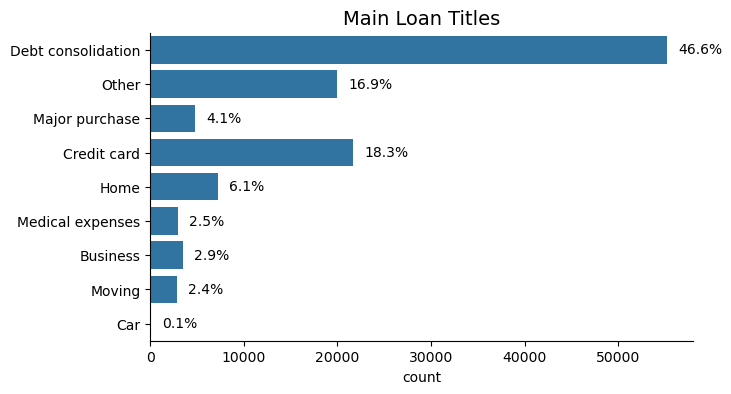

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
sns.countplot(y=df['Loan_Title_Grouped'], color="tab:blue")

total = len(df['Loan_Title_Grouped'])
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.01 * total, p.get_y() + p.get_height() / 2, f'{width/total:.1%}', va='center')

plt.title('Main Loan Titles', fontsize=14)
ax.set(ylabel="")
sns.despine()

The above are the main categories of Loan Titles, we see that many of these titles were grouped in the category Other.

<h3 style="color:#484E6E">Debt-To-Income Ratio</h3>

In [17]:
df['Debt-To-Income_Ratio'][df['Debt-To-Income_Ratio'] < 0].value_counts()

Debt-To-Income_Ratio
-1.000    4422
Name: count, dtype: int64

As discussed before, there are many clients with a -1 'Debt-To-Income Ratio', which probably can be explained by them not having an income.
A new column will be created to highlight the appearence of these values.

In [18]:
df['has_Income'] = df['Debt-To-Income_Ratio'].apply(lambda x: 'yes' if x!=-1 else 'no')
df[['Debt-To-Income_Ratio', 'has_Income']].head(7)

,Debt-To-Income_Ratio,has_Income
0,21.160,yes
1,5.970,yes
2,1.810,yes
3,207.210,yes
4,100.000,yes
5,13.460,yes
6,24.850,yes


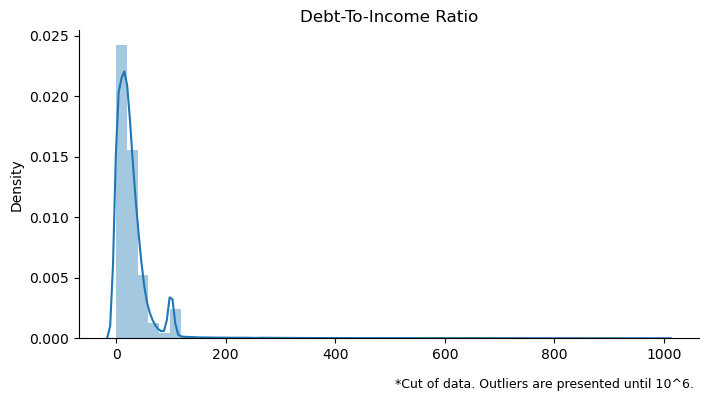

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.distplot(x=df["Debt-To-Income_Ratio"][df["Debt-To-Income_Ratio"] < 1_000], ax=ax)

ax.set(title="Debt-To-Income Ratio")
ax.set(xlabel="")
ax.text(0.75, -0.15, "*Cut of data. Outliers are presented until 10^6.", transform=ax.transAxes, fontsize=9, ha='center', va='center')
sns.despine()

<h3 style="color:#484E6E">Risk Score</h3>

According to the metadata, for applications prior to November 5, 2013 the risk score is the borrower's FICO score. After this date, the risk score is the borrower's VantageScore. These evaluation metrics take into account the borrower's data on payment history, the current level of indebtedness, types of credit used, length of credit history, and new credit accounts.

**FICO Scores range from 300 to 850**. **VantageScore** featured a different numerical scale (**501 to 990**). However, in versions 3.0 and 4.0 adopted the same scale that FICO uses.

FICO scores are **used in 90% of mortgage application** decisions in the United States. **Scores in the 670 to 739 range are considered to be “good”** credit scores.

Outside of this notebook, we have noticed that the information on the metadata is not completely accurate. Before the 5th Nov 2013, the FICO Score highest value was already in the range of the Vantage Score. In this context, no new feature will be created to highlight this difference between scores.

Let's show the **distribution of this feature**.

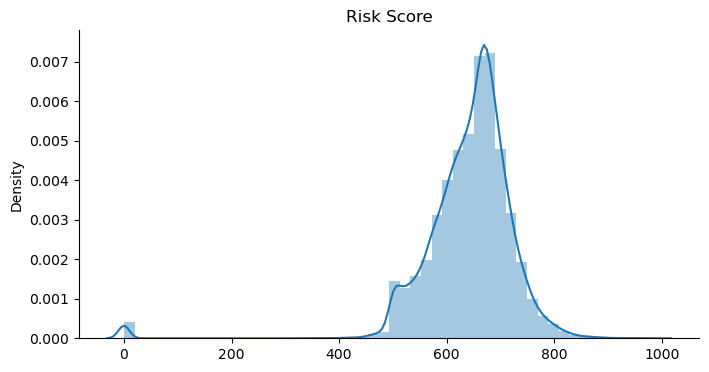

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.distplot(x=df["Risk_Score"][df['Risk_Score']>=0], ax=ax)

ax.set(title="Risk Score")
ax.set(xlabel="")
sns.despine()

Some **0 values** are presented in this feature and **should be treated a Null** (not in the range).

As discussed before, our dataframe presents about 61% of null values. It is a big proportion of the dataframe and, due to its importance in the financing industry, the removal of these loan requests is not the best method to use.

In this case, **a new column will be generated to consider the clients who did not provide this value and the null values will be filled with -1** (similarly to Debt-to-Income Ratio). The same will be carried out for values equals to 0.

In [21]:
df['provided_Risk_Score'] = df['Risk_Score'].apply(lambda x: 'no' if x is None or np.isnan(x) or x==0 else 'yes')
df['Risk_Score'][(df['Risk_Score'].isna()) | (df['Risk_Score'] == 0)] = -1
df[['Risk_Score', 'provided_Risk_Score']].head(7)

,Risk_Score,provided_Risk_Score
0,-1.000,no
1,592.000,yes
2,552.000,yes
3,-1.000,no
4,-1.000,no
5,-1.000,no
6,-1.000,no


<h3 style="color:#484E6E">Employment Length</h3>

Lastly in this section, we can show the distribution of clients in relation to their employment time. Most of them have worked less than 1 year. Followed by clients who worked 5 years.

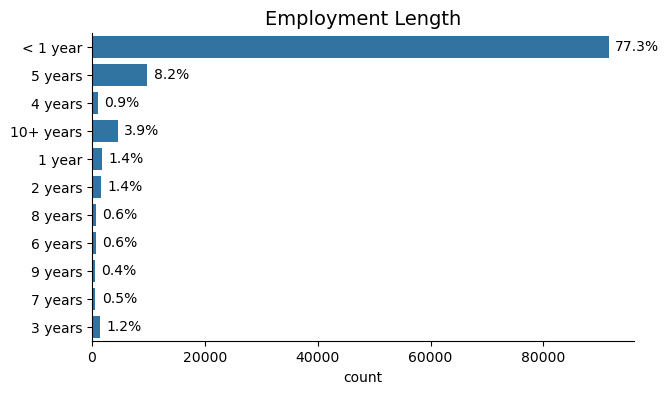

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
sns.countplot(y=df['Employment_Length'], color="tab:blue")

total = len(df['Employment_Length'])
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.01 * total, p.get_y() + p.get_height() / 2, f'{width/total:.1%}', va='center')

plt.title('Employment Length', fontsize=14)
ax.set(ylabel="")
sns.despine()

<h2 style="color:#484E6E">Multivariate Analysis of Features</h2>

Let's start this part by checking how the **distribution of the continous features relate to our target**.

Important to notice that the following plots **only show proportions of the dataset, not a correlation**!!

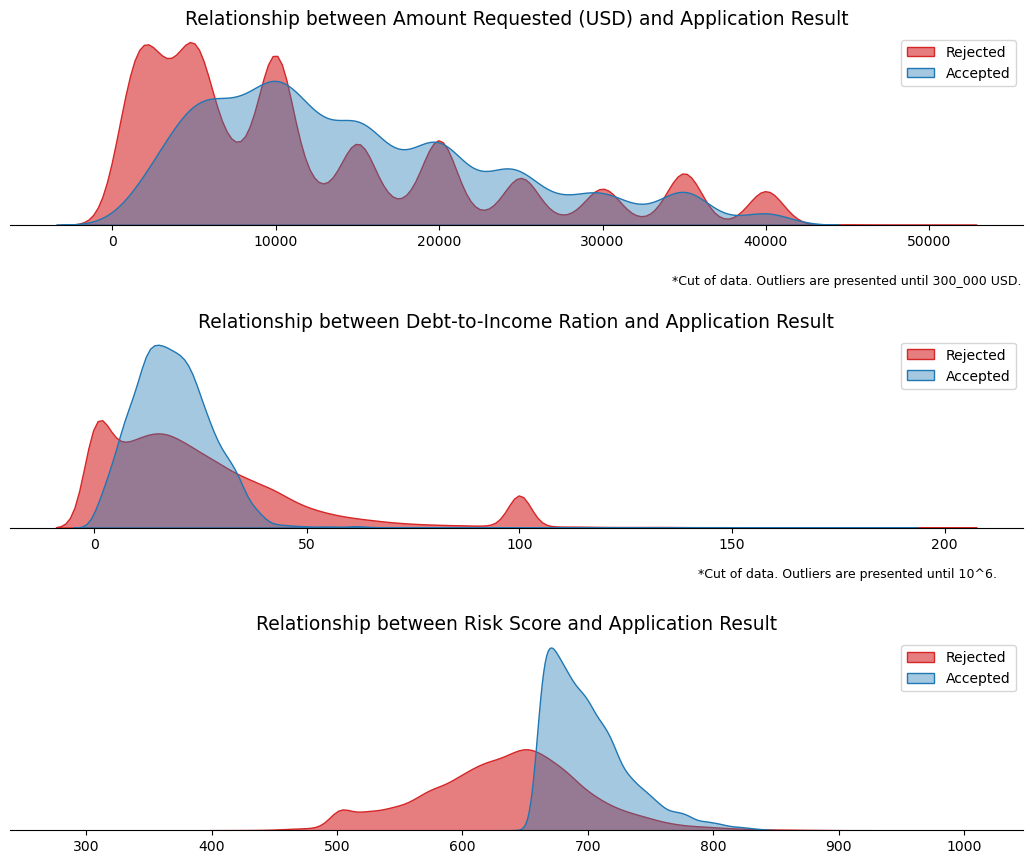

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(11, 9))

condition = [(df["Amount_Requested"] < 50_000), (df["Debt-To-Income_Ratio"] < 200), (df['Risk_Score'] > 0)]

for i, col in enumerate(num_features):
    sns.kdeplot(
        data=df[df["Application_Result"] == "Rejected"][condition[i]],
        x=col,
        ax=axes[i],
        shade=True,
        color="tab:red",
        alpha=0.6,
    )
    sns.kdeplot(
        data=df[df["Application_Result"] == "Accepted"][condition[i]],
        x=col,
        ax=axes[i],
        shade=True,
        color="tab:blue",
        alpha=0.4,
    )
    sns.despine(left=True)

    axes[i].set_yticklabels("")
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis="y", length=0)
    axes[i].legend(["Rejected", "Accepted"], loc="upper right")

axes[0].set_title("Relationship between Amount Requested (USD) and Application Result", fontsize=13.5)
axes[1].set_title("Relationship between Debt-to-Income Ration and Application Result", fontsize=13.5)
axes[2].set_title("Relationship between Risk Score and Application Result", fontsize=13.5)

axes[0].text(1.4, 1.75, "*Cut of data. Outliers are presented until 300_000 USD.", transform=ax.transAxes, fontsize=9, ha='center', va='center')
axes[1].text(1.4, 0.8, "*Cut of data. Outliers are presented until 10^6.", transform=ax.transAxes, fontsize=9, ha='center', va='center')

plt.tight_layout(pad=2)

There is no clear pattern between the Application Result with the Amount Requested.

For the **Debt-to-Income ratio**, one can see that the proportion of **clients with higher debts** (to income) **who got accepted is very low**.

As commented before, **risk scores above 650 are considered good**, as we can see a lot of the **clients in this range got their loan accepted**.


Let's see how the **policy code** changes with our target.

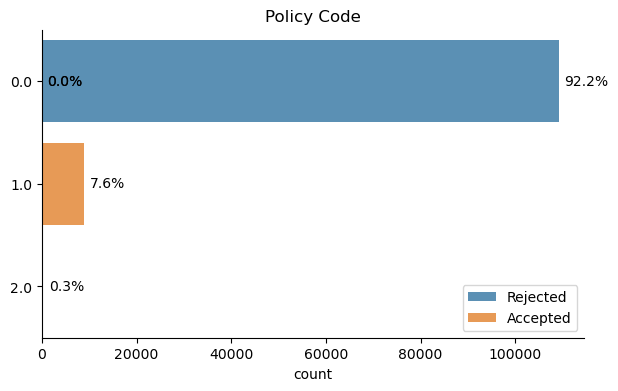

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

sns.countplot(
    y=df["Policy_Code"],
    hue=df["Application_Result"],
    alpha=0.8,
    ax=ax,
)

total = len(df['Policy_Code'])
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.01 * total, p.get_y() + p.get_height() / 2, f'{width/total:.1%}', va='center')

ax.legend(["Rejected", "Accepted"], loc="lower right")
ax.set(ylabel="", xlabel="count", title="Policy Code")
sns.despine()

According to the metadata, the policy code is divided in:
- publicly available policy_code=1
- new products not publicly available policy_code=2

As we can see, all of the accepted data is located in the Policy Code 1, that means this feature would be a direct predictor for a our model and threfore should be dropped.


We can also see if the **employment type influences the being given a loan**.

In [25]:
df.head()

,Amount_Requested,Loan_Title,Risk_Score,Debt-To-Income_Ratio,Zip_Code,State,Employment_Length,Policy_Code,Application_Result,Loan_Title_Grouped,has_Income,provided_Risk_Score
0,10000.000,Debt consolidation,-1.000,21.160,207xx,MD,< 1 year,0.000,Rejected,Debt consolidation,yes,no
1,5000.000,Other,592.000,5.970,150xx,PA,< 1 year,0.000,Rejected,Other,yes,yes
2,1000.000,debt_consolidation,552.000,1.810,212xx,MD,< 1 year,0.000,Rejected,Debt consolidation,yes,yes
3,10000.000,Major purchase,-1.000,207.210,376xx,TN,< 1 year,0.000,Rejected,Major purchase,yes,no
4,35000.000,Debt consolidation,-1.000,100.000,967xx,HI,< 1 year,0.000,Rejected,Debt consolidation,yes,no


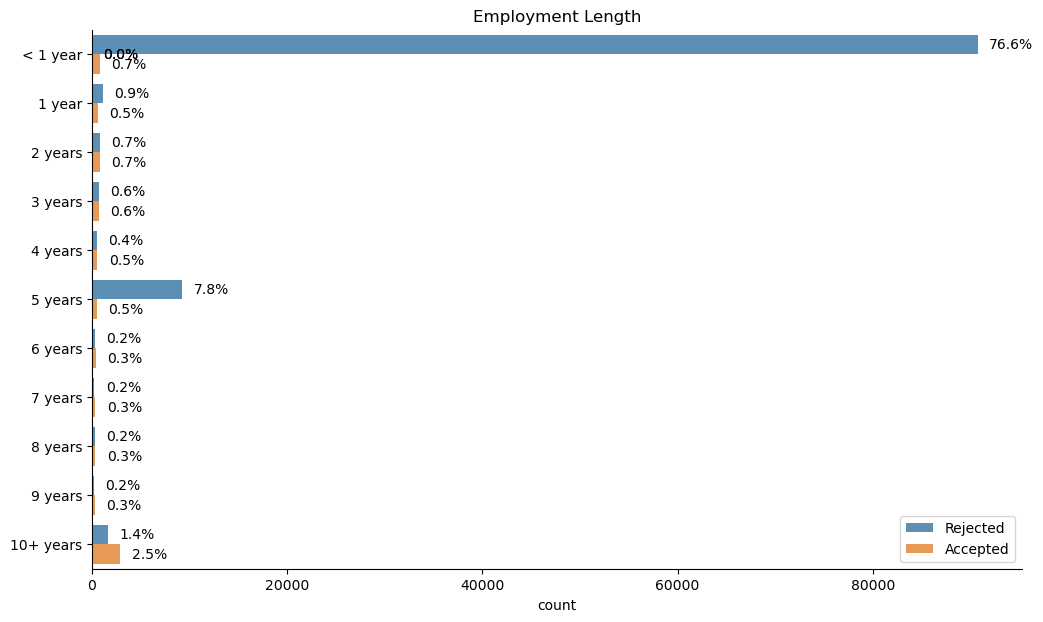

In [26]:
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sns.countplot(
    y=df["Employment_Length"],
    hue=df["Application_Result"],
    alpha=0.8,
    ax=ax,
    order=order
)

total = len(df['Employment_Length'])
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.01 * total, p.get_y() + p.get_height() / 2, f'{width/total:.1%}', va='center')

ax.legend(["Rejected", "Accepted"], loc="lower right")
ax.set(ylabel="", xlabel="count", title="Employment Length")
sns.despine()

As we can see, the greatest proportion of rejected loans happened to clients with less than 1 year of work experience. Followed by people with 5 years, which I imagine are people trying to buy their first houses.

The proportion of accepted loans is, to some extent, increasing with the work experience.

<h2 style="color:#484E6E">Correlation of Features</h2>

<h3 style="color:#484E6E">Categorical</h3>

Let's take a look at how the features are the correlated. Before showing the heatmap, we run a simple label enconder on the features.

We also manually apply the encoding for Application Result:

**Accepted: 1**

**Rejected: 0**

In [27]:
df["Application_Result"] = df["Application_Result"].map({"Accepted": 1, "Rejected": 0})
df["Application_Result"].value_counts()

Application_Result
0    109484
1      8955
Name: count, dtype: int64

In [28]:
encoder = LabelEncoder()
df_obj_enc = (
    df.select_dtypes("object")
    .drop(["Loan_Title", "Zip_Code"], axis=1)
    .merge(df["Policy_Code"], left_index=True, right_index=True)
    .apply(encoder.fit_transform)
).merge(df["Application_Result"], left_index=True, right_index=True)

df_obj_enc.head()

,State,Employment_Length,Loan_Title_Grouped,has_Income,provided_Risk_Score,Policy_Code,Application_Result
0,20,10,3,1,0,0,0
1,38,10,8,1,1,0,0
2,20,10,3,1,1,0,0
3,42,10,5,1,0,0,0
4,11,10,3,1,0,0,0


In order to analyze the correlation of our target feature to the other categories we will calculate the **Cramer's V coefficient**. Unlike the Pearson's Correlation Coeficient, it **ranges between 0 and 1**, being 1 the highest correlation values.

It takes into consideration the **Chi-Square value**.

√(X2/N) / min(C-1, R-1)

Here, 

- X2: It is the Chi-square statistic
- N: It represents the total sample size
- R: It is equal to the number of rows
- C: It is equal to the number of columns

In [29]:
def cramers_v(data, col1, col2):
    '''Function to calculate Cramér's V for a pair of columns'''
    contingency_table = pd.crosstab(data[col1], data[col2])
    X2 = chi2_contingency(contingency_table, correction=False)[0]
    n = np.sum(contingency_table.values)
    minDim = min(contingency_table.shape) - 1
    V = np.sqrt((X2 / n) / minDim)
    return V

cramers_v_values = []

for i in range(len(df_obj_enc.columns)):
    for j in range(len(df_obj_enc.columns)):
        col1 = df_obj_enc.columns[i]
        col2 = df_obj_enc.columns[j]
        v = cramers_v(df_obj_enc, col1, col2)
        cramers_v_values.append((col1, col2, v))

cramers_v_df = pd.DataFrame(cramers_v_values, columns=['Column1', 'Column2', 'Cramers_V'])
correlation_matrix = cramers_v_df.pivot(index='Column1', columns='Column2', values='Cramers_V')
correlation_matrix = correlation_matrix.rename_axis(index=None, columns=None)

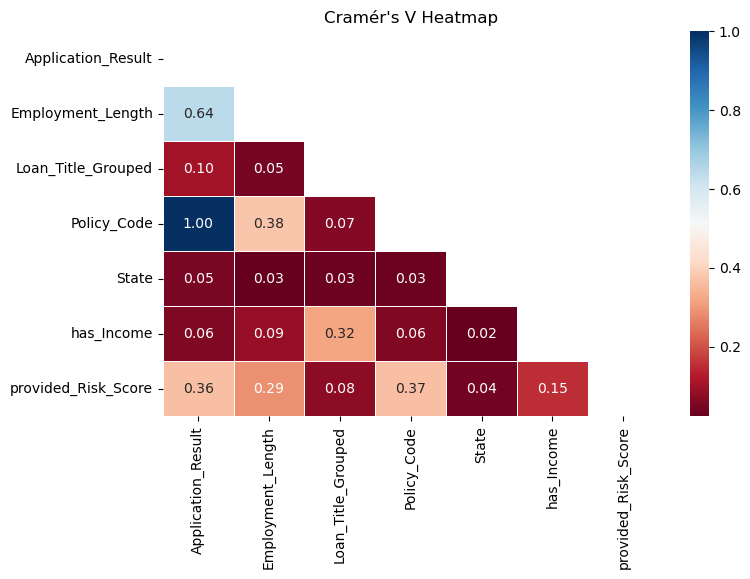

In [30]:
matrix = np.triu(correlation_matrix)

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu", fmt=".2f", linewidths=.5, mask=matrix)
plt.title("Cramér's V Heatmap");

This heatmap highlights:
- the **positive correlation** between the **employment length** and our target.
- it also sees some **weak correlation with the provided risk score**.
- as we can see also here, Policy Code is a direct predictor for the our target.

<h3 style="color:#484E6E">Numerical</h3>

In [31]:
target = df_obj_enc["Application_Result"]
df_num = (
    df.select_dtypes("number")
    .drop(["Policy_Code", "Application_Result"], axis=1)
)

df_num[df_num["Debt-To-Income_Ratio"].isna()] = -1
df_num.head()

,Amount_Requested,Risk_Score,Debt-To-Income_Ratio
0,10000.000,-1.000,21.160
1,5000.000,592.000,5.970
2,1000.000,552.000,1.810
3,10000.000,-1.000,207.210
4,35000.000,-1.000,100.000


In order to analyze the correlation of our target feature to the numerical ones we will calculate the **Point-biserial correlation**. Like the Pearson's Correlation Coeficient, it also **ranges between -1 and 1**, with 0 representing non-correlated values.

The correlation between the continuous features amongst themselves will be performed through person's correlation coefficient.

In [32]:
point_biserial_values = []

for col in df_num.columns:
    r, p_value = pointbiserialr(df_num[col], target)
    point_biserial_values.append((col, r, p_value))

point_biserial_df = pd.DataFrame(point_biserial_values, columns=['Feature', 'Application_Result', 'P_Value']).set_index('Feature').rename_axis(index=None, columns=None)
point_biserial_df.loc['Application_Result'] = 1
point_biserial_df

,Application_Result,P_Value
Amount_Requested,0.032,0.000
Risk_Score,0.409,0.000
Debt-To-Income_Ratio,-0.012,0.000
Application_Result,1.000,1.000


In [33]:
correlation_matrix = df_num.corr()
correlation_matrix = correlation_matrix.merge(point_biserial_df['Application_Result'], left_index=True, right_index=True)
correlation_matrix = pd.concat([correlation_matrix, point_biserial_df.drop('P_Value', axis=1).T], axis=0)
correlation_matrix

,Amount_Requested,Risk_Score,Debt-To-Income_Ratio,Application_Result
Amount_Requested,1.000,0.014,0.001,0.032
Risk_Score,0.014,1.000,-0.007,0.409
Debt-To-Income_Ratio,0.001,-0.007,1.000,-0.012
Application_Result,0.032,0.409,-0.012,1.000


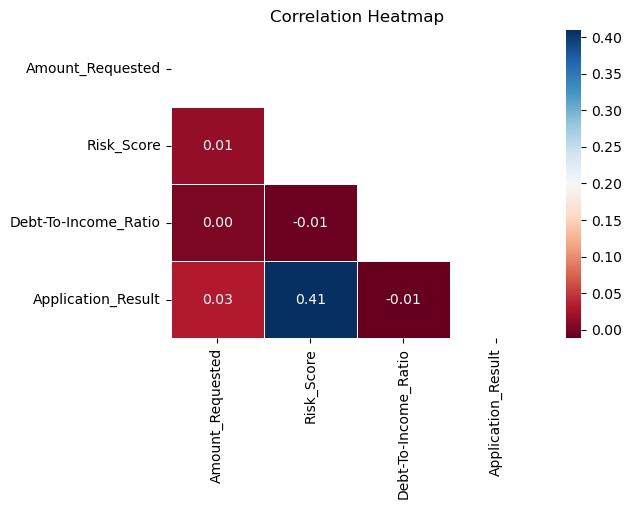

In [34]:
matrix = np.triu(correlation_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu", fmt=".2f", linewidths=.5, mask=matrix)
plt.title("Correlation Heatmap");

The only important highlight of this heatmap is the **positive correlation between Risk Score and Application Result** (The highest the Risk Score (FICO), the lowest the chance of getting a rejected claim - encoded as 0).

The continuous features don't appear to be correlated between themselves.

<h2 style="color:#484E6E">Univariate Feature Importance</h2>

In this section, we run a simple test to **find out the features that have most importance for  the target** variable. 

We can assume that the **higher the score in the SelektKBest, the higher the importance** of the feature. However, this is a individual analysis of feature-i and target, **in reality** due to the interaction between features **the results of a multivariate importance can be very differen**t.

Due to the **categorical nature** of the features, this importance is evaluated through a **chi-squared test**.

In [35]:
X = df_obj_enc.drop("Application_Result", axis=1)
y = df_obj_enc["Application_Result"]

bestfeature_obj = SelectKBest(score_func=chi2, k="all")
bf_obj = bestfeature_obj.fit(X, y)

bestfeature_num = SelectKBest(score_func=f_classif, k="all")
bf_num = bestfeature_num.fit(df_num, y)

In [36]:
score = pd.concat([pd.DataFrame(bf_obj.scores_), pd.DataFrame(bf_num.scores_)], axis=0)
colnames = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(df_num.columns)], axis=0)
bf_result = pd.concat([colnames, score], axis='columns')
bf_result.columns = ['Feature','Score']
bf_result.nlargest(10,'Score')

,Feature,Score
5,Policy_Code,100706.056
1,Employment_Length,24829.882
1,Risk_Score,23828.472
4,provided_Risk_Score,9763.261
2,Loan_Title_Grouped,621.603
0,State,127.793
0,Amount_Requested,124.953
2,Debt-To-Income_Ratio,16.230
3,has_Income,14.028


According to the SelectKBest algorithm, **Employment_Length and Risk_Score are the most influencing features** on Accepting or Rejecting a Loan.

<p style = "background:	#f6eeee; color:black"> This part of EDA provided some <b>good insights about the features</b> that are most likely important to the prediction acceptance/rejection of a loan, i.e. Employment Length, Risk Score.<br><br>
We continue now in our next notebook to model this. Let's create our pipelines, check how a baseline model would score on our only moderately modified dataset and jump into the models.</p>